In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/Major Project 8th sem/Code/data/AMZN_1years_15Min.csv')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(raw_data.shape)
raw_data.head()

(11880, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2021-05-03 04:15:00,3480.05,3480.05,3480.05,3480.05,723
1,1,2021-05-03 04:30:00,3485.00,3485.00,3485.00,3485.00,159
2,2,2021-05-03 05:15:00,3479.00,3479.00,3479.00,3479.00,206
3,3,2021-05-03 05:30:00,3478.00,3478.00,3476.00,3476.00,604
4,4,2021-05-03 06:15:00,3470.00,3470.00,3470.00,3470.00,1257


In [5]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

In [6]:
# reversing the dataframe 
close_ds_rev = close_ds.loc[::-1, :]
close_ds_rev = close_ds_rev.reset_index(drop=True)
close_ds_rev.head()

,time,close
0,2022-04-26 20:00:00,2814.00
1,2022-04-26 19:30:00,2814.80
2,2022-04-26 19:15:00,2810.01
3,2022-04-26 19:00:00,2808.00
4,2022-04-26 18:45:00,2808.00


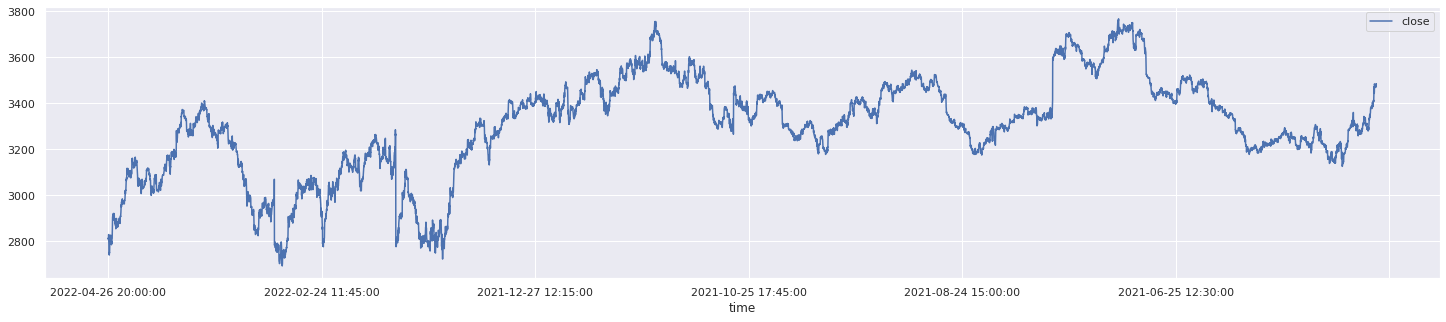

In [7]:
close_ds_rev.plot(x='time', y='close', figsize=(25, 5))

In [8]:
# converting time serires into a supervised learning problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# n_in ---> number of previous data points (lag observations) to consider as input
# n_out --> number of datapoints to predict
# dataset ----> dataframe with (n_in + n_out + 1 [for current timestamp]) numbers of columns used for supervised training of the model 

n_in = 50
n_out = 1
dataset = series_to_supervised(close_ds_rev.drop('time', axis=1), n_in, n_out)
print(dataset.shape)
dataset.head()

(11829, 52)


,close(t-50),close(t-49),close(t-48),close(t-47),close(t-46),close(t-45),close(t-44),close(t-43),close(t-42),close(t-41),...,close(t-8),close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1),close(t),close(t+1)
50,2814.00,2814.80,2810.01,2808.00,2808.00,2829.95,2804.60,2765.88,2758.79,2751.0000,...,2907.6323,2908.00,2908.22,2915.00,2902.00,2917.51,2919.50,2921.4800,2917.4000,2918.2500
51,2814.80,2810.01,2808.00,2808.00,2829.95,2804.60,2765.88,2758.79,2751.00,2744.9200,...,2908.0000,2908.22,2915.00,2902.00,2917.51,2919.50,2921.48,2917.4000,2918.2500,2919.0000
52,2810.01,2808.00,2808.00,2829.95,2804.60,2765.88,2758.79,2751.00,2744.92,2741.0000,...,2908.2200,2915.00,2902.00,2917.51,2919.50,2921.48,2917.40,2918.2500,2919.0000,2919.9472
53,2808.00,2808.00,2829.95,2804.60,2765.88,2758.79,2751.00,2744.92,2741.00,2753.0000,...,2915.0000,2902.00,2917.51,2919.50,2921.48,2917.40,2918.25,2919.0000,2919.9472,2916.5100
54,2808.00,2829.95,2804.60,2765.88,2758.79,2751.00,2744.92,2741.00,2753.00,2749.9047,...,2902.0000,2917.51,2919.50,2921.48,2917.40,2918.25,2919.00,2919.9472,2916.5100,2921.4800


In [10]:
# train test split

from sklearn.model_selection import train_test_split
target = dataset.loc[:, ['close(t+1)']]
features = dataset.drop('close(t+1)', axis=1)
print(target.shape)
print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11829, 1)
(11829, 51)
(8280, 51)
(8280, 1)
(3549, 51)
(3549, 1)


In [11]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# Multilayer perceptron 

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
mlp_history = model_mlp.fit(X_train.values, y_train.values, validation_data=(X_test.values, y_test.values), epochs=40, verbose=2)

Epoch 1/40
259/259 - 1s - loss: 349518.3438 - val_loss: 967.0850 - 1s/epoch - 5ms/step
Epoch 2/40
259/259 - 1s - loss: 1789.4976 - val_loss: 931.8403 - 514ms/epoch - 2ms/step
Epoch 3/40
259/259 - 0s - loss: 1783.3384 - val_loss: 957.3614 - 479ms/epoch - 2ms/step
Epoch 4/40
259/259 - 0s - loss: 1779.2111 - val_loss: 1010.9976 - 468ms/epoch - 2ms/step
Epoch 5/40
259/259 - 0s - loss: 1784.4374 - val_loss: 907.9586 - 480ms/epoch - 2ms/step
Epoch 6/40
259/259 - 0s - loss: 1777.8202 - val_loss: 1285.8440 - 496ms/epoch - 2ms/step
Epoch 7/40
259/259 - 1s - loss: 1744.8694 - val_loss: 866.9542 - 539ms/epoch - 2ms/step
Epoch 8/40
259/259 - 1s - loss: 1707.5894 - val_loss: 861.5118 - 523ms/epoch - 2ms/step
Epoch 9/40
259/259 - 1s - loss: 1667.6776 - val_loss: 838.6063 - 509ms/epoch - 2ms/step
Epoch 10/40
259/259 - 0s - loss: 1676.4432 - val_loss: 922.8737 - 491ms/epoch - 2ms/step
Epoch 11/40
259/259 - 0s - loss: 1644.5377 - val_loss: 1342.0054 - 499ms/epoch - 2ms/step
Epoch 12/40
259/259 - 0s - l

Text(0, 0.5, 'MSE')

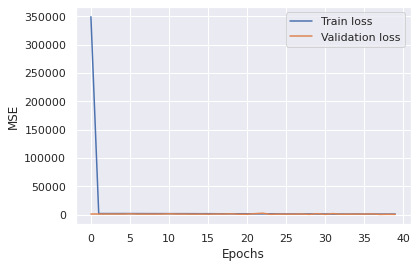

In [13]:
# plots 
fig = plt.figure()
plt.plot(mlp_history.history['loss'], label='Train loss')
plt.plot(mlp_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [14]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
mlp_train_pred = model_mlp.predict(X_train)
mlp_test_pred = model_mlp.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, mlp_test_pred)))

Train rmse: 24.35915865512561
Validation rmse: 17.92735521272203


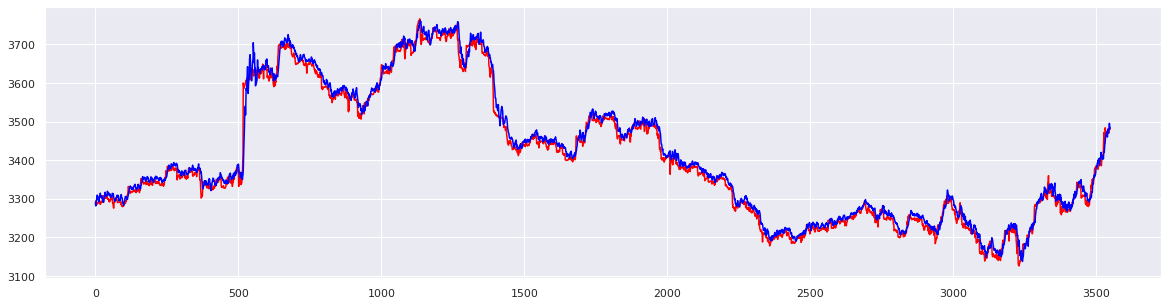

In [15]:

plt.figure(figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True), color='red')
plt.plot(mlp_test_pred, color='blue')